# RGI03 (Arctic Canada North)

F. Maussion & S. Galos

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import (mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, 
                   find_duplicates, open_zip_shapefile, correct_geoms, fix_overaps)
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 3

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '03_rgi60_ArcticCanadaNorth.zip')

# Supporting shapes and data
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

N         A                                           analysts  \
subm_id                                                                      
255       626   11927.7                                            Hartman   
356       200    3414.5                                            Hartman   
358       178   19021.4                                            Hartman   
359       183    5710.7                                           Cawkwell   
590      4538  105015.3  Barrand, Burgess, Cawkwell, Copland, Filbert, ...   
625         4      22.2                                        Braun, Raup   
626         4      13.3                              Bradley, Braun, Hardy   
627         2       6.9                                               Raup   
628         2       4.7                                               Raup   
629         2       5.7                                               Raup   
630         2       3.2                                               Raup   
631         2       1.3                                               Raup   
632         3       0.7                                               Raup   
633         2       0.5                                               Raup   
634         2       3.6                                               Raup   
635         7     128.2                  Berthier, Bolch, Cogley, Kienholz   
645         2       0.2                                               Raup   
660        10      50.5                             Maydhisudhiwongs, Raup   
661        12      15.0                             Maydhisudhiwongs, Raup   
711      1569   26108.2                                     Copland, White   
712       442    2791.9                                     Copland, White   
713      2154   27244.0                                     Copland, White   
723      2583   27691.6                               Paul, Rastner, White   
728      1968   37675.5         Copland, Kochtitzky, Thomson, Zajaczkiwsky   
755        23      33.9                                         Kochtitzky   

         submitters  release_date  \
subm_id                             
255         Hartman          2006   
356         Hartman          2006   
358         Hartman          2006   
359         Hartman          2006   
590           Bolch          2015   
625            Raup          2016   
626            Raup          2016   
627            Raup          2016   
628            Raup          2016   
629            Raup          2016   
630            Raup          2016   
631            Raup          2016   
632            Raup          2016   
633            Raup          2016   
634            Raup          2016   
635          Cogley          2015   
645            Raup          2017   
660            Raup          2018   
661            Raup          2018   
711           White          2019   
712           White          2019   
713           White          2019   
723            Paul          2021   
728      Kochtitzky          2021   
755      Kochtitzky          2021   

                                                 geog_area  src_date_mode  \
subm_id                                                                     
255                                                 Canada           1999   
356                                                 Canada           1997   
358                                                 Canada           1999   
359                                                 Canada           2002   
590      Randolph Glacier Inventory; Umbrella RC for me...           1999   
625                                        Various (NSIDC)           1959   
626                                        Various (NSIDC)           2001   
627                                        Various (NSIDC)           2001   
628                                        Various (NSIDC)           2005   
629                                        Various (NSIDC)

Notes based on inidivual submission evaluations: 

- 590: This is the RGI, without Melville Island
- 635: are seven glaciers on Melville Island, yet not what is used by RGI6 (RGI6 outlines for Melville are not available in GLIMS)
- 660, 661: also Melville Island. A bit further to 2000 than 635.
- 728: Three parts: Elsemere (Central), Axel Heiberg, Ellesmere (South West). To be used in RGI7?
- 723: Ellesmere North - to be used in RGI7
- 713, 712, 711: Ellesmere North - too late, not for RGI7
- 755: missing outlines added by Will: https://github.com/GLIMS-RGI/rgi7_scripts/issues/34

In [5]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

### Read in the geometry data for sub-inventory selection 

In [6]:
# Read L2 files
shp_loc = gpd.read_file('tar://' + support_dir + f'/sub_inventory_sel_RGI03.tar.gz/sub_inventory_sel_RGI03.shp')

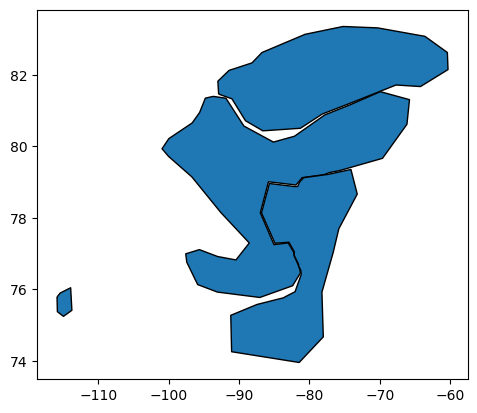

In [7]:
shp_loc.plot(edgecolor='k');

In [8]:
shp_loc

id             info  subm_id  \
0   0         Melville      635   
1   1             None      728   
2   2  Ellesmere North      723   
3   4             None      590   

                                            geometry  
0  POLYGON ((-115.87499 75.78899, -115.42617 75.8...  
1  POLYGON ((-93.67317 81.39727, -91.87755 81.346...  
2  POLYGON ((-92.90937 81.46119, -93.02105 81.821...  
3  POLYGON ((-82.15135 78.87694, -81.67968 78.879...

In [9]:
# Test the polygons I drew - each subregion should be equivalent as the sel by id
# (Except RGI6 which will be replaced in parts)
for sub_id in [635, 728, 723]:
    sel = shp.loc[shp['subm_id'] == sub_id].copy()
    rp = sel.representative_point().to_frame('geometry')
    rp['orig_index'] = sel.index
    intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == sub_id], how='intersection')
    odf = sel.loc[intersect['orig_index']]
    assert len(sel) == len(odf)

### Apply selection criteria to create the RGI7 data subset

In [10]:
# Melville
rgi7_Melville = shp.loc[shp['subm_id'].isin([635])].copy()
print(len(rgi7_Melville))
rgi7_Melville = size_filter(rgi7_Melville)
print(len(rgi7_Melville))

rgi7_Melville['is_rgi6'] = False

7
7


In [11]:
# Ellesmere North
rgi7_North = shp.loc[shp['subm_id'].isin([723])].copy()
print(len(rgi7_North))
rgi7_North = size_filter(rgi7_North)
print(len(rgi7_North))

rgi7_North['is_rgi6'] = False

2583
2581


In [12]:
# Ellesmere Central + Axel Heiberg
rgi7_Central = shp.loc[shp['subm_id'].isin([728])].copy()
print(len(rgi7_Central))
rgi7_Central = size_filter(rgi7_Central)
print(len(rgi7_Central))

rgi7_Central['is_rgi6'] = False

1968
1961


In [13]:
# Addons from Will: https://github.com/GLIMS-RGI/rgi7_scripts/issues/34
rgi7_Addons = shp.loc[shp['subm_id'].isin([755])].copy()
print(len(rgi7_Addons))
rgi7_Addons = size_filter(rgi7_Addons)
print(len(rgi7_Addons))

rgi7_Addons['is_rgi6'] = False

23
23


In [14]:
# Rest (Devon, East, etc)
rgi7_South = shp.loc[shp['subm_id'].isin([590])].copy()
print(len(rgi7_South))

# Sel by canvas
rp = rgi7_South.representative_point().to_frame('geometry')
rp['orig_index'] = rgi7_South.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 590], how='intersection')
rgi7_South = rgi7_South.loc[intersect['orig_index']]

# Sel by size
print(len(rgi7_South))
rgi7_South = size_filter(rgi7_South)
print(len(rgi7_South))

rgi7_South['is_rgi6'] = True

4538
653
653


In [15]:
# combine the geodataframes
rgi7 = pd.concat([rgi7_Melville, rgi7_North, rgi7_Central, rgi7_Addons, rgi7_South])

In [16]:
# Sel by size
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

5225
5225


In [17]:
# This is a triangle
len_bef = len(rgi7)
rgi7 = rgi7.loc[rgi7.anlys_id != 308558].copy()  # G281934E76633N
assert len(rgi7) == (len_bef - 1)

### Some sanity checks 

In [18]:
dupes = find_duplicates(rgi7) 

Potential duplicates: 12


In [19]:
# for i in np.arange(1, 12, 2):
#     plt.figure();
#     f, axs = plt.subplots(1, 2)
#     dupes.iloc[[i-1]].plot(ax=axs[0]);
#     dupes.iloc[[i]].plot(ax=axs[1]);
# The first 4 pairs are duplicates, the last two pairs are really weird shapes that belong deleted

In [20]:
to_remove = dupes.iloc[[1, 3, 5, 7, 8, 9, 10, 11]]
rgi7 = rgi7.loc[~rgi7.anlys_id.isin(to_remove.anlys_id)]
find_duplicates(rgi7);

Seems Okay!


In [21]:
rgi7 = correct_geoms(rgi7)

Found 49 invalid geometries out of 5216.
After correction, 0 geometries are still invalid.
Area changed by -681.9 m2 (-0.0000%, or 0 tiny glaciers)


In [22]:
rgi7 = fix_overaps(rgi7)

Finding intersecting geometries
Computing overlap of intersecting pairs
Found 510 overlaps out of 5216. Correcting...
After correction, Area changed by -18850.6 m2 (-0.0000%, or -1 tiny glaciers)
Final check...
Finding intersecting geometries
Computing overlap of intersecting pairs
OK! Check done


In [23]:
rgi7 = correct_geoms(rgi7)

Found 0 invalid geometries out of 5216.


In [24]:
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

5216
5216


In [25]:
sdf, df_class = submission_summary(rgi7)
df_class

N  N NA
subm_id            
635         7     7
723      2573  2573
728      1961  1961
755        23    23
590       652   652

In [26]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

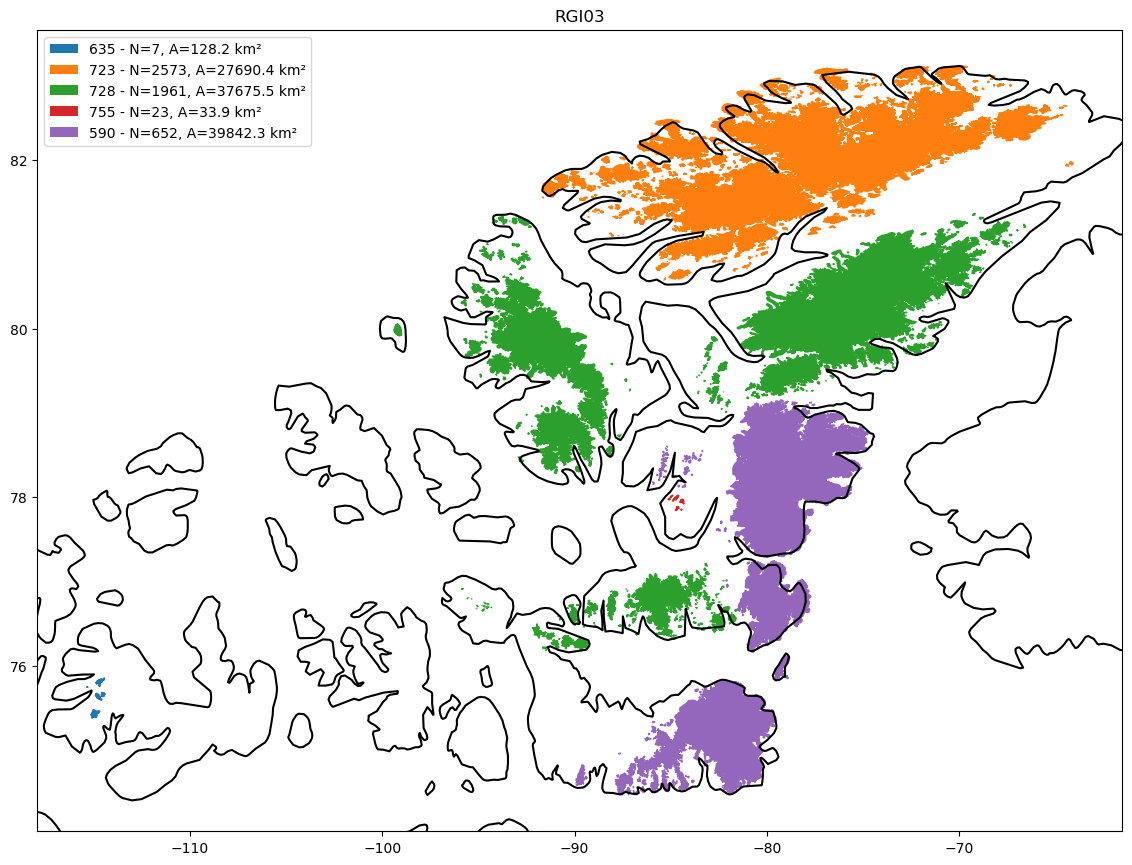

In [27]:
plot_map(rgi7, reg, loc='upper left')

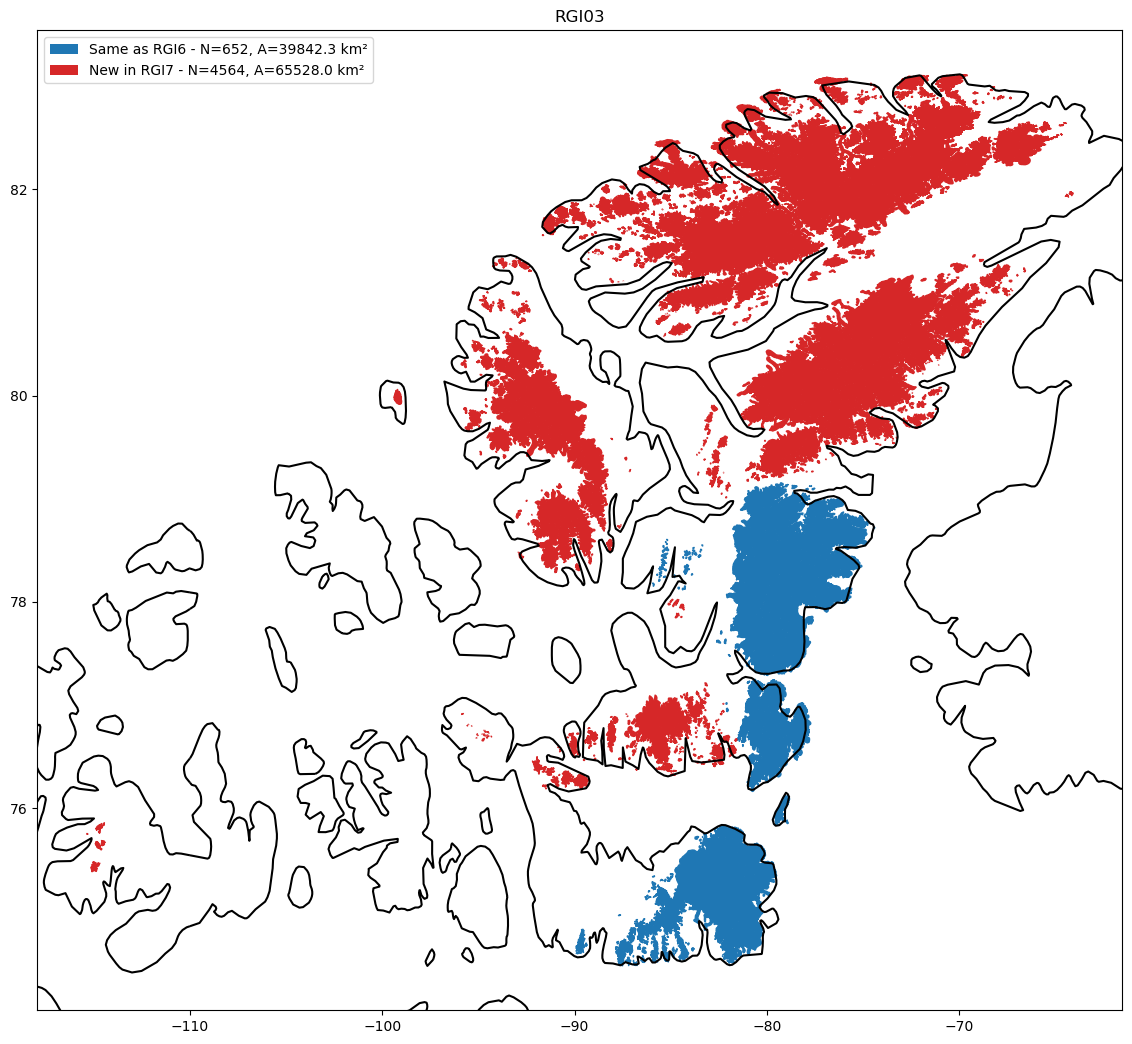

In [28]:
plot_map(rgi7, reg, loc='upper left', is_rgi6=True)

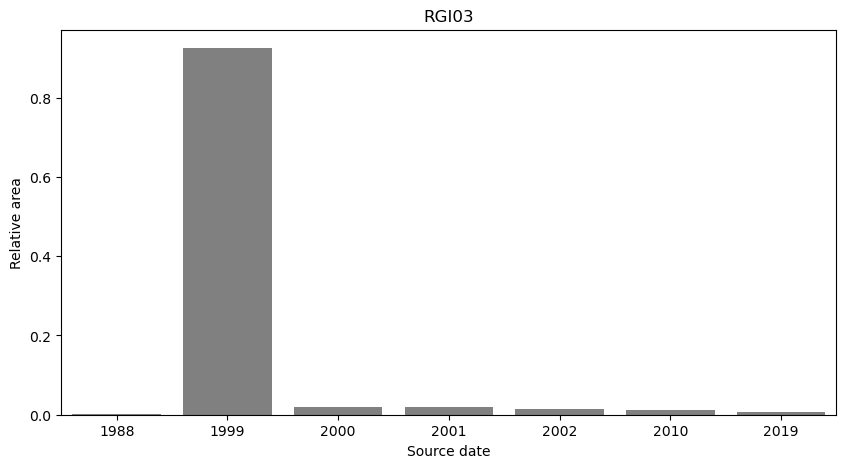

In [29]:
plot_date_hist(rgi7, reg)

### Text for github

In [30]:
fgh = sdf.T
fgh

subm_id                                                      635  \
N                                                              7   
A                                                          128.2   
analysts                       Berthier, Bolch, Cogley, Kienholz   
submitters                                                Cogley   
release_date                                                2015   
geog_area      Randolph Glacier Inventory; Umbrella RC for me...   
src_date_mode                                               1988   
src_date_min                                                1988   
src_date_max                                                1988   

subm_id                          723  \
N                               2573   
A                            27690.4   
analysts        Paul, Rastner, White   
submitters                      Paul   
release_date                    2021   
geog_area      Various (GlobGlacier)   
src_date_mode                   1999   
src_date_min                    1999   
src_date_max                    2019   

subm_id                                               728         755  \
N                                                    1961          23   
A                                                 37675.5        33.9   
analysts       Copland, Kochtitzky, Thomson, Zajaczkiwsky  Kochtitzky   
submitters                                     Kochtitzky  Kochtitzky   
release_date                                         2021        2021   
geog_area                                          Canada      Canada   
src_date_mode                                        1999        2001   
src_date_min                                         1999        2001   
src_date_max                                         2002        2001   

subm_id                                                      590  
N                                                            652  
A                                                        39842.3  
analysts       Barrand, Burgess, Cawkwell, Copland, Filbert, ...  
submitters                                                 Bolch  
release_date                                                2015  
geog_area      Randolph Glacier Inventory; Umbrella RC for me...  
src_date_mode                                               1999  
src_date_min                                                1999  
src_date_max                                                1999

In [31]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 635                                                                    | 723                   | 728                                        | 755        | 590                                                                                                     |
|:--------------|:-----------------------------------------------------------------------|:----------------------|:-------------------------------------------|:-----------|:--------------------------------------------------------------------------------------------------------|
| N             | 7                                                                      | 2573                  | 1961                                       | 23         | 652                                                                                                     |
| A             | 128.2                                                                  | 27690.4               | 37675.5                                    | 33.

## Write out and tar 

In [32]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI03/
RGI03/RGI03.dbf
RGI03/RGI03.shp
RGI03/RGI03.shx
RGI03/RGI03.cpg
RGI03/RGI03.prj
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI03.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI03'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6 and Frank's) to enable comparison

In [ ]:
# load reference data
from utils import open_zip_shapefile

# RGI6
ref_rgi6 = open_zip_shapefile(rgi6_reg_file)
# FP
ref_fp = open_zip_shapefile(os.path.join(support_dir, 'c3s_gi_rgi03_l7_1999_v1.zip'))
# Will
ref_wk = open_zip_shapefile(os.path.join(support_dir, 'RGI6_Kochtitzky_final_3Sep2021.zip'))

### Compare new RGI7-file to RGI6

### Number of elements (differences do not depict problems)

In [ ]:
print('Number of glaciers in new RGI:', len(rgi7))
print('Number of glaciers in RGI6:', len(ref_rgi6))
print('Difference:', len(rgi7)-len(ref_rgi6))

### How many nominal glaciers were there in RGI06?

In [ ]:
len(ref_rgi6.loc[ref_rgi6.Status == 2])

### Total area

In [ ]:
# add an area field to RGI_ss and reference data
ref_rgi6['area'] = ref_rgi6.to_crs({'proj':'cea'}).area
ref_fp['area'] = ref_fp.to_crs({'proj':'cea'}).area
ref_wk['area'] = ref_wk.to_crs({'proj':'cea'}).area

In [ ]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_rgi6['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

### Northern Ellesmere (723, Frank Paul, no problem there):  

In [ ]:
print('Number of glaciers in RGI7 subset:', len(rgi7_North))
print('Number of glaciers in reference data (FP):', len(ref_fp))
print('Difference:', len(rgi7_North)-len(ref_fp))

In [ ]:
# print and compare area values
Area_7 = rgi7_North['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_fp['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

This is brilliant! No issue there.

### Central Ellesmere (728, Coppland, no problem there):  

In [ ]:
print(len(ref_wk))
ref_wk = ref_wk.loc[np.round(ref_wk['area'] * 1e-6, 3) >= 0.01].copy()
len(ref_wk)

In [ ]:
print('Number of glaciers in RGI7 subset:', len(rgi7_Central))
print('Number of glaciers in reference data (FP):', len(ref_wk))
print('Difference:', len(rgi7_Central)-len(ref_wk))

In [ ]:
# print and compare area values
Area_7 = rgi7_Central['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_wk['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

This is brilliant! No issue there.

### Southern Ellesmere (590, RGI6, no problem there):  

In [ ]:
rp = ref_rgi6.representative_point().to_frame('geometry')
rp['orig_index'] = ref_rgi6.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 590], how='intersection')
ref_rgi6_south = ref_rgi6.loc[intersect['orig_index']].copy()

In [ ]:
print('Number of glaciers in RGI7 subset:', len(rgi7_South))
print('Number of glaciers in reference data (RGI6):', len(ref_rgi6_south))
print('Difference:', len(rgi7_South)-len(ref_rgi6_south))

In [ ]:
# print and compare area values
Area_7 = rgi7_South['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_rgi6_south['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Almost no issue - some weird polygon outcrops here and there. 

### Melville Island (635) not much to compare here

In [ ]:
rp = ref_rgi6.representative_point().to_frame('geometry')
rp['orig_index'] = ref_rgi6.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 635], how='intersection')
ref_rgi6_melville = ref_rgi6.loc[intersect['orig_index']].copy()

In [ ]:
print('Number of glaciers in RGI7 subset:', len(rgi7_Melville))
print('Number of glaciers in reference data (RGI6):', len(ref_rgi6_melville))
print('Difference:', len(rgi7_Melville)-len(ref_rgi6_melville))

In [ ]:
# print and compare area values
Area_7 = rgi7_Melville['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_rgi6_melville['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

In [ ]:
f, ax = plt.subplots(figsize=(14, 14))
rgi7_Melville.plot(ax=ax, facecolor='None', edgecolor='C0');
ref_rgi6_melville.plot(ax=ax, facecolor='None', edgecolor='C3');
ax.legend(handles=[
            mpatches.Patch(facecolor='C0', label='635 - Berthier'),
            mpatches.Patch(facecolor='C3', label='RGI6'),
          ], loc='upper left');